<a href="https://colab.research.google.com/github/Sharika224/Automated-Detection-and-Classification-of-Gastrointestinal-Bleeding-in-Wireless-Capsule-Endoscopy/blob/main/WCEBleedGen_Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [ ]:
  import tensorflow as tf
  import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2. Load Dataset

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/My\ Drive/WCEBleedGen.zip


Archive:  drive/My Drive/WCEBleedGen.zip
replace WCEBleedGen/bleeding/img- (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('WCEBleedGen')

Found 2618 files belonging to 2 classes.


In [ ]:
# we cannot fetch data directly so we are using numpy iterator
data_iterator = data.as_numpy_iterator()

In [ ]:
data_iterator

In [ ]:
batch = data_iterator.next()

In [ ]:
len(batch) # batch contians image and its label

2

In [ ]:
# Image represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [ ]:
# 0 -> bleed
# 1 -> non bleed

batch[1]

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

In [ ]:
class_labels = ["GI Bleeding", "No GI Bleeding"]
'''
0 => GI Bleeding
1 => No GI Bleeding '''

'\n0 => GI Bleeding\n1 => No GI Bleeding '

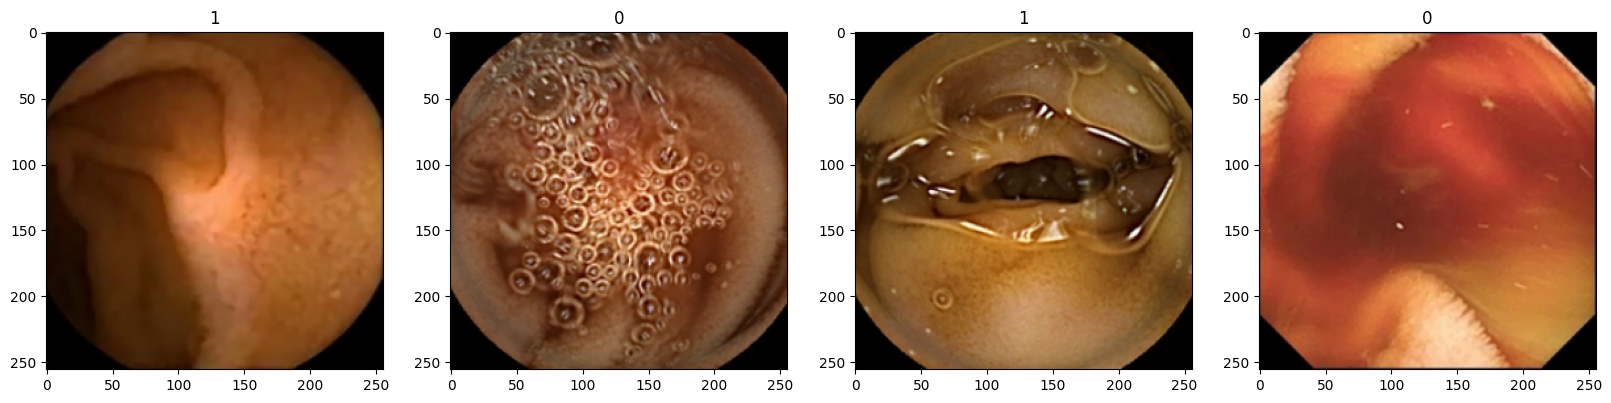

In [ ]:
# in above we cannot detect which one (bleed or not bleed ) is represented by 0 or 1 so we are plotting to check that

fig , ax = plt.subplots(ncols=4, figsize=(20 ,20))
for idx , img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

3. Preprocessing

In [ ]:
# SCALE Data

# x -> image & y -> label
#  We are changing the rgb scale (that vary from 0 to 255) so that it is min which is the best to optimize
data = data.map(lambda x , y : (x / 255 , y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

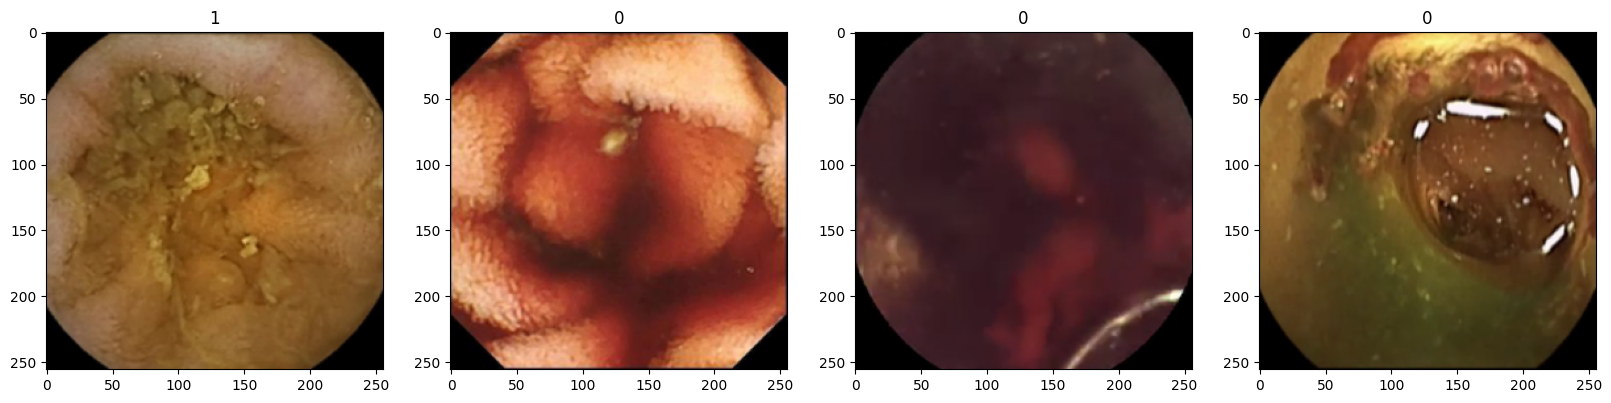

In [ ]:
fig , ax = plt.subplots(ncols=4, figsize=(20 ,20))
for idx , img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

82

In [ ]:
#SPLIT DATA

train_size = int(len(data)*.7)
val_size = int(len(data) * .1)
test_size = int(len(data)*.2)+1

In [ ]:
train_size

57

In [ ]:
test_size

17

In [ ]:
val_size

8

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

4. Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2

In [ ]:
import tensorflow_probability as tfp

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

Train


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
from collections import Counter

# Extract labels from the train dataset
train_labels = np.concatenate([y for x, y in train], axis=0)

# Calculate class frequencies
class_counts = Counter(train_labels)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights
class_weights = {class_idx: total_samples / (num_samples * len(class_counts)) for class_idx, num_samples in class_counts.items()}


In [ ]:
hist = model.fit(train, epochs=15, validation_data=val, class_weight=class_weights, callbacks=[tensorboard_callback])


Epoch 1/15
57/57 [==============================] - 125s 2s/step - loss: 0.4880 - accuracy: 0.7462 - val_loss: 0.1816 - val_accuracy: 0.9531
Epoch 2/15
57/57 [==============================] - 131s 2s/step - loss: 0.2026 - accuracy: 0.9265 - val_loss: 0.1981 - val_accuracy: 0.9375
Epoch 3/15
57/57 [==============================] - 129s 2s/step - loss: 0.1443 - accuracy: 0.9496 - val_loss: 0.1610 - val_accuracy: 0.9297
Epoch 4/15
57/57 [==============================] - 120s 2s/step - loss: 0.0896 - accuracy: 0.9644 - val_loss: 0.1459 - val_accuracy: 0.9492
Epoch 5/15
57/57 [==============================] - 120s 2s/step - loss: 0.0579 - accuracy: 0.9808 - val_loss: 0.0648 - val_accuracy: 0.9844
Epoch 6/15
57/57 [==============================] - 129s 2s/step - loss: 0.0263 - accuracy: 0.9923 - val_loss: 0.0794 - val_accuracy: 0.9688
Epoch 7/15
57/57 [==============================] - 130s 2s/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0687 - val_accuracy: 0.9766
Epoch 8/15
57

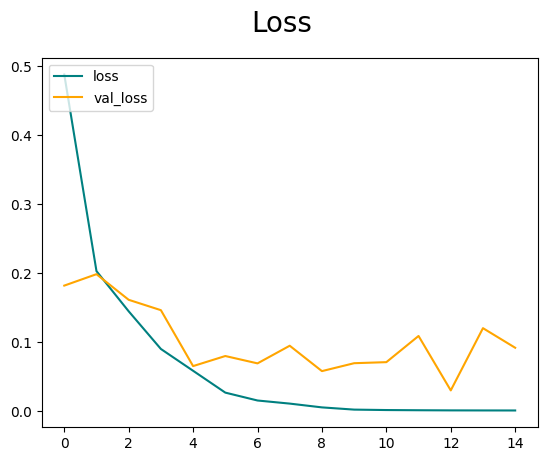

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

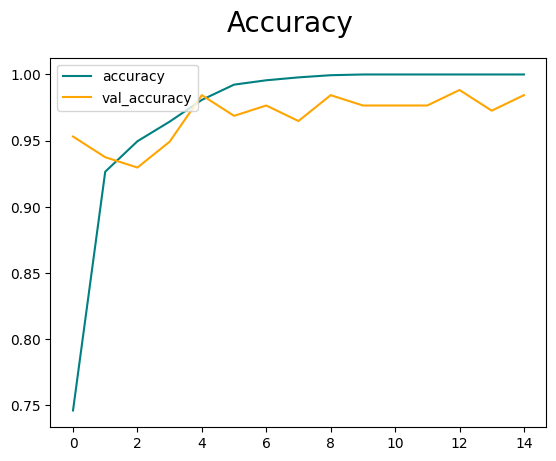

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Save The Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
